In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm

plt.style.use("../config/custom_plt.mplstyle")

In [2]:
labels = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_label.txt")

labels = np.argmax(labels, axis=1)

labels = pd.DataFrame(labels)
labels.reset_index(inplace=True)
labels.columns = ['index', 'label']
labels.head()

,index,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [3]:
categories = labels['label'].unique()
colormap = cm.get_cmap('Set1', len(categories))

/tmp/ipykernel_3579608/3370728750.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Set1', len(categories))


In [4]:
category_to_colormap = dict(zip(categories, range(len(categories))))
category_to_colormap

{1: 0, 0: 1, 2: 2}

## Exploring node features

In [5]:
from sklearn.metrics.pairwise import *

features = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_feature.txt", dtype=int)

features = pd.DataFrame(features)
features.columns = [f'f{i}' for i in features.columns]
features.reset_index(inplace=True)
features.head()

,index,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1990,f1991,f1992,f1993,f1994,f1995,f1996,f1997,f1998,f1999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
import networkx as nx

# g = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/data/imdb/imdb_mam.edge",
#                      nodetype=int)

g = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_mam/eS2/imdb_mam_GC.edge",
                     nodetype=int)

gcc_edges_idx = list(g.nodes)

gcc_edges_idx.sort()
gcc_edges_idx[:5]

[0, 1, 2, 3, 4]

In [7]:
len(gcc_edges_idx)

3228

In [8]:
data = features.merge(labels, on="index")
data.index = data.index.astype(str)

# Only consider GCC !!!
data = data[data['index'].isin(gcc_edges_idx)]

data

,index,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1991,f1992,f1993,f1994,f1995,f1996,f1997,f1998,f1999,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3539,3539,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,2
3540,3540,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3543,3543,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3545,3545,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


## Dimensional reduction of the nodes' features using UMAP

In [9]:
from sklearn import preprocessing
from sklearn.utils import shuffle


X = data.drop(["index", "label"], axis=1).values

le = preprocessing.LabelEncoder()
y = le.fit_transform(data['label'].values)

X[:5], y[:5]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([1, 1, 1, 1, 1]))

In [10]:
np.mean(X.sum(axis=1))

76.95508054522925

In [10]:
%%time
from sklearn.model_selection import train_test_split
from umap.umap_ import UMAP
np.random.seed(12)

reducer = UMAP(metric='cosine', random_state=61)

X_umap = reducer.fit_transform(X)
X_umap.shape

CPU times: user 28.5 s, sys: 525 ms, total: 29.1 s
Wall time: 28.5 s


(3228, 2)

Text(0.5, 1.0, 'UMAP dim=2')

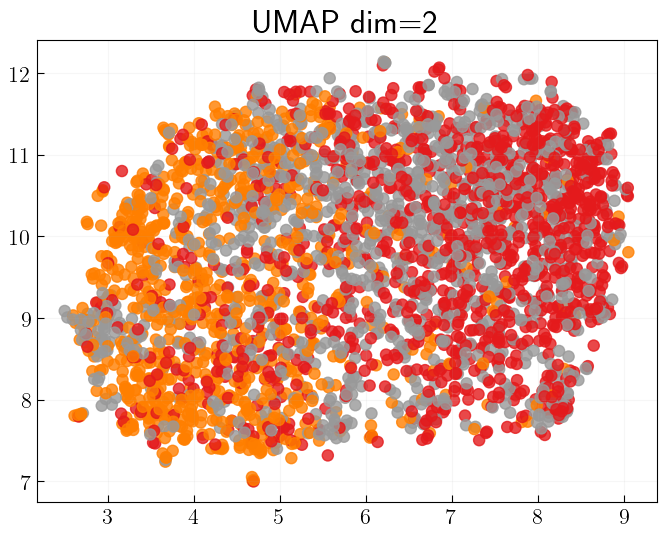

In [11]:
from matplotlib.lines import Line2D

plt.scatter(X_umap[:, 0], X_umap[:, 1], color=[colormap(i) for i in y], alpha=0.8)
plt.title('UMAP dim=2')

### Check non-euclidean embeddings

https://umap-learn.readthedocs.io/en/latest/embedding_space.html

**Spherical embeddings**

In [12]:
sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=61).fit(X) 

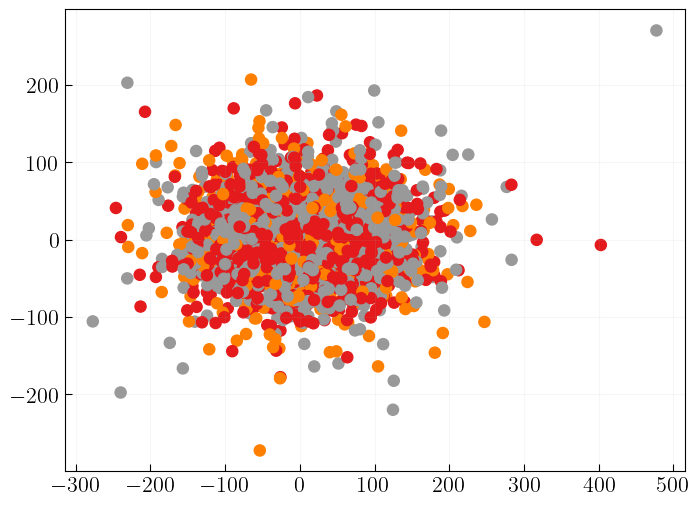

In [13]:
plt.scatter(sphere_mapper.embedding_.T[0], sphere_mapper.embedding_.T[1], c=[colormap(i) for i in y])

In [14]:
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])

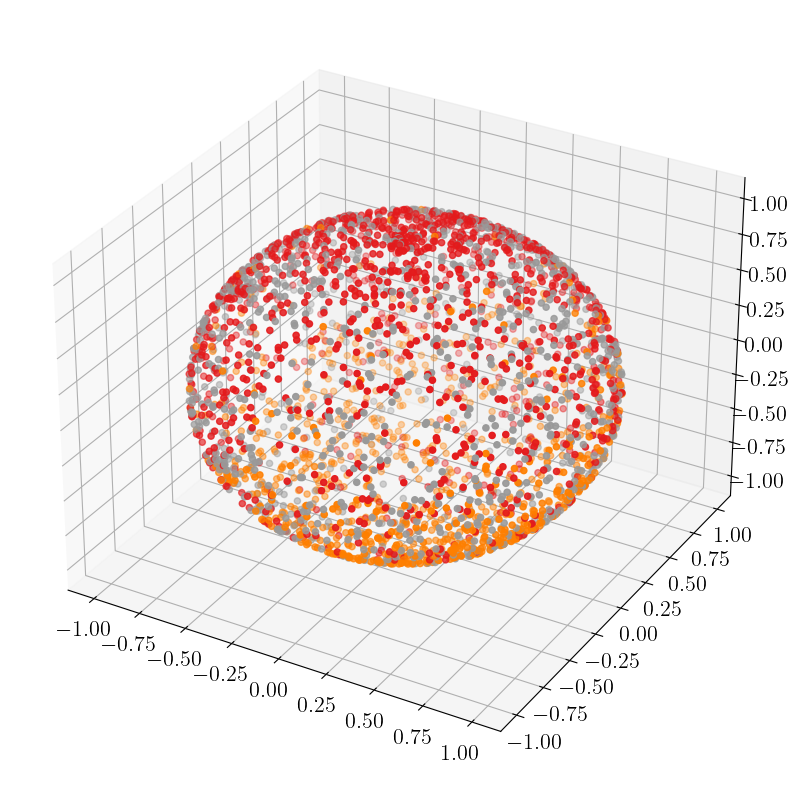

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, c=[colormap(i) for i in y])

In [16]:
vectors = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

In [17]:
idx = data['index'].values
idx
# np.c_[idx, vectors]

array([   0,    1,    2, ..., 3543, 3545, 3546])

In [18]:
vectors[:10]

array([[-0.01868362,  0.12229814, -0.99231756],
       [-0.45316935,  0.48498076, -0.7479513 ],
       [ 0.26048642, -0.02605111, -0.965126  ],
       [ 0.37281868,  0.0055446 , -0.9278877 ],
       [-0.4400445 ,  0.38707212, -0.8102691 ],
       [-0.31969607, -0.71034765, -0.62705714],
       [-0.4555045 ,  0.7452008 , -0.48702297],
       [-0.25194514, -0.01191932, -0.9676681 ],
       [ 0.1337268 , -0.27211782, -0.9529266 ],
       [-0.42697898,  0.45983464, -0.7786148 ]], dtype=float32)

In [19]:
# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/data/imdb/umap/only_gcc/umap_imdb_spherical_positions_only_gcc.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [20]:
# F-Mercator


# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/umap_imdb_spherical_positions_gcc.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [27]:
%%time

sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=2).fit(X)
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])
vectors2 = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

CPU times: user 50.8 s, sys: 560 ms, total: 51.3 s
Wall time: 56.8 s


100%|██████████| 3228/3228 [09:18<00:00,  5.78it/s]


The best Z-axis rotation angle:  5.129130863003743


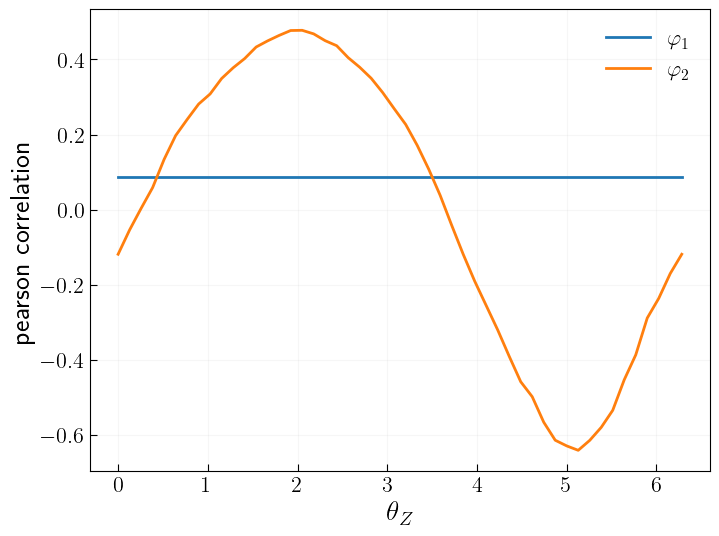

In [28]:
from lib.check_inferred_embeddings import *

real_coords_all, inf_coords_all, real_coords_spherical, inf_coords_spherical = \
    apply_pipeline_matrix_with_loading_and_rotate_all_euclidean_use_all_nodes(vectors, vectors2)

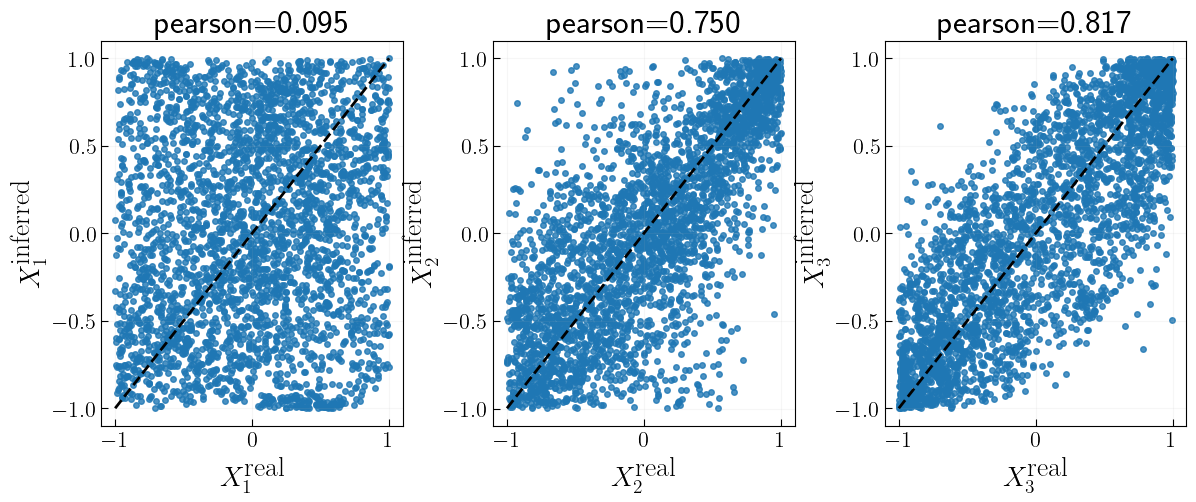

In [29]:
plot_euclidean_coordinates_comparison(inf_coords_all, real_coords_all)